In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import seaborn as sns
from sklearn.decomposition import PCA
sys.path.append('../')
from utils import *
from processing import *
import cv2 as cv
from image_registration import *

from skimage import color
import scipy as sp

import SimpleITK as sitk
from skimage.transform import rescale,resize
from pystackreg import StackReg
from PIL import Image

import ipywidgets as widgets
from ipywidgets import Box, IntSlider

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


No module named 'brainpy._c.composition'

          SPIKE
    Version     : 0.99.30
    Date        : 22-03-2022
    Revision Id : 563
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 


In [2]:
import pickle
with open('../processed_data/Coronal3D_UMAP_datainfo_decoded.pkl', 'rb') as fp:
    UMAP_datainfo = pickle.load(fp)
    
slice_order = ['slide1_2_R00','slide1_2_R01','slide1_2_R02','slide1_2_R03','slide1_2_R04','slide1_2_R05','slide1_2_R06',
              'slide1_2_R07','slide1_2_R08','slide3_5_R00','slide3_5_R10','slide3_5_R01','slide3_5_R02','slide3_5_R03',
              'slide3_5_R04','slide4_6_R00','slide4_6_R11','slide4_6_R01','slide4_6_R02','slide4_6_R03','slide4_6_R04',
              'slide3_5_R05','slide3_5_R06','slide3_5_R07','slide3_5_R08','slide3_5_R11','slide3_5_R09','slide4_6_R05',
              'slide4_6_R06','slide4_6_R07','slide4_6_R08','slide4_6_R09','slide4_6_R10','slide7_R00','slide7_R01',
              'slide7_R02','slide7_R03']
# no_transform = ['slide3_4_R01']
# rotate_slice = ['slide1_2_R13','slide1_2_R12','slide1_2_R11','slide1_2_R10','slide1_2_R09','slide1_2_R08','slide1_2_R05','slide1_2_R04','slide1_2_R03']

In [3]:
import h5py
def pad(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(int)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(int)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(int)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(int)
    return np.copy(np.pad(img, [(top_pad, bottom_pad), (left_pad, right_pad)], mode='constant'))
idx = 0
umap_imgs = []
spec_idx_imgs = []
for slice in slice_order:
    data = UMAP_datainfo[slice_order[idx]]
    coord = data['coordinates']
    embedding = data['embeddings'][:,[1,7,8]]
    umap_img = color.rgb2gray(hyperspectral_vis(embedding,coord,True).transpose(1,0,2))
    umap_img = (umap_img - np.min(umap_img)) / (np.max(umap_img) - np.min(umap_img))
    spec_idx_img = IonImg(np.arange(1,embedding.shape[0]+1),coord,True,False)
    umap_img = pad(umap_img,512,512)
    spec_idx_img = pad(spec_idx_img,512,512)
    umap_imgs.append(umap_img)
    spec_idx_imgs.append(spec_idx_img)
    idx +=1

In [4]:
import nibabel as nib
file_dir = '../'
epi_labels = nib.load(file_dir+'WHS_SD_rat_atlas_v2.nii.gz')
epi_t2 = nib.load(file_dir+'WHS_SD_rat_T2star_v1.01.nii.gz')
epi_fa = nib.load(file_dir+'WHS_SD_rat_FA_color_v1.01.nii.gz')

epi_labels_data = epi_labels.get_fdata()
epi_t2_data = epi_t2.get_fdata()

In [5]:
mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500,365,360,355,350,330,325,320,310,305,295,290,280,275,270,265]

mri_imgs = []
label_imgs = []
for i in range(len(mri_slice_num)):
    slice_no = mri_slice_num[i]

    label_slice = epi_labels_data[:, slice_no, :].copy()
    mri_slice = epi_t2_data[:, slice_no, :].copy()
    label_slice_mask = label_slice.copy()
    label_slice_mask[label_slice_mask>0] =1

    mri_slice_masked = mri_slice*label_slice_mask
    #mri_slice_masked = (mri_slice_masked - np.min(mri_slice_masked)) / (np.max(mri_slice_masked) - np.min(mri_slice_masked))
    mri_slice_masked = mri_slice_masked/mri_slice_masked.max()
    #mri_slice_masked[label_slice_mask==0]+=1
    mri_slice_masked = np.flip(mri_slice_masked.T)
    mri_slice_label = np.flip(label_slice.T)

    mri_imgs.append(mri_slice_masked)
    label_imgs.append(mri_slice_label)

In [5]:
from scipy.io import loadmat
spec_idx_transformed = loadmat('../image_register/Matlab Registration/coronal_registration/spec_idx_imgs_transformed.mat')['spec_idx_imgs_transformed']

In [6]:
mzs_3d = np.load('../processed_data/coronal3d_mz.npy')

In [1]:
def load_data(file):
    with open(file, 'rb') as fp:
        data = pickle.load(fp)
        mz = data['mz']
        print(mz.shape)
        peak_data = data['peak_data']
        coord = []
        if 'coordinates' in data.keys():
            coord = data['coordinates']
    #intens_mtx = intens_mtx/tic.reshape(-1,1)
    return mz,peak_data,coord

slice_no = 9
input_dir = '/Volumes/Elements/3DCoronal/imzml/'
f_name = input_dir+'coronal3D_latent32_epoch10_{}_propagated_decoded.imzML'.format(slice_order[slice_no])
imzml_data = loadimzMLData(f_name)

In [52]:
intens_array, mz_bins_use, c = extractMZFeatures(imzml_data, ppm=3, mz_range=(400,1100), feature_n=0.2)

number of mass bins 168602


100%|█████████████████████████████████████████████████████████████████████████████████████| 168602/168602 [00:35<00:00, 4695.86it/s]


In [53]:
mz_bins_use.shape

(2682,)

IndexError: arrays used as indices must be of integer (or boolean) type

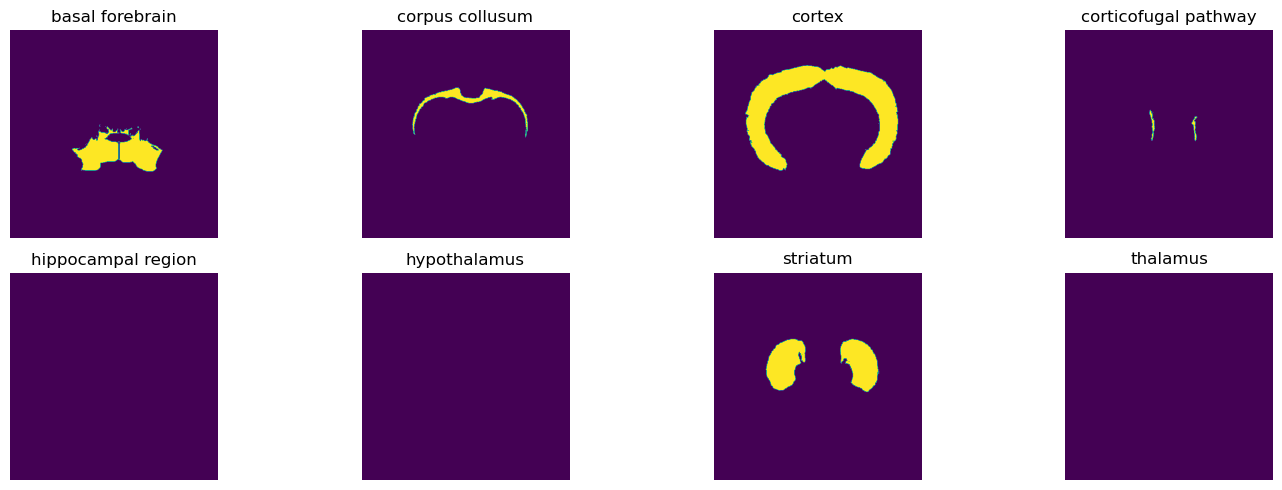

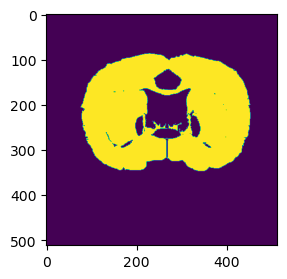

In [54]:
atlas_region = {'basal forebrain':82,'corpus collusum':67,'cortex':92,'corticofugal pathway':1,'hippocampal region':[95,96,97,98],'hypothalamus':48,'striatum':30,'thalamus':39}
slice_no = 4
fig,axes = plt.subplots(2,4,figsize=(15,5))
ax = axes.ravel()
idx = 0
for key in atlas_region.keys():
    ax[idx].imshow((np.isin(label_imgs[slice_no], atlas_region[key])))
    ax[idx].axis('off')
    ax[idx].set_title(key)
    idx+=1
fig.tight_layout()
fig,axes = plt.subplots(1,1,figsize=(3,3))
axes.imshow((np.isin(label_imgs[slice_no], [92,30,67,39,1,95,96,97,98,48,82])))

regions = []
data = []
for key in atlas_region.keys():
    region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1))))
    region_data = intens_array[region_idx[region_idx>=0]]
    data.append(region_data)
    regions+=[key]*region_data.shape[0]

In [55]:
slice_no = 4
intens_mtx = intens_array
atlas_region = {'basal forebrain':82,'corpus collusum':67,'cortex':92,'corticofugal pathway':1,'hippocampal region':[95,96,97,98],'hypothalamus':48,'striatum':30,
                'thalamus':39,'brainstem':47,'superior colliculus':[50,55],'septal region':40}
regions = []
data = []
for key in atlas_region.keys():
    region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1))))
    if region_idx.shape[0]>int(0.01*intens_mtx.shape[0]):
        region_data = intens_mtx[region_idx[region_idx>=0]]
        data.append(region_data)
        regions+=[key]*region_data.shape[0]

In [13]:
sys.path.append('../scms_py')
from scMSData import scMSData
from analysis import scMSAnalysis

with open('../peak_data_sc_regional_decode.pkl', 'rb') as handle:
    peak_data_decode = pickle.load(handle)
names = list(peak_data_decode.keys())
scms_decode = scMSData()
scms_decode.names = names

In [14]:
peak_data_hip = {}
for key in peak_data_decode.keys():
    if 'Hip' in key:
        peak_data_hip[key] = peak_data_decode[key]

In [56]:
scms_decode.peak_list = peak_data_hip

In [24]:
keys = list(peak_data_hip.keys())

with ImzMLWriter('../peak_data_sc_hip_decode'+'.imzML') as w:

    for i in tqdm(range(len(keys))):
        # writes data to the .ibd file
        #print(i)
        if peak_data_decode[keys[i]]['mz'].size >0:
            w.addSpectrum(mzs = peak_data_hip[keys[i]]['mz'], intensities = peak_data_hip[keys[i]]['intensity'], coords = tuple([1,i]))

100%|█████████████████████████████████████| 2692/2692 [00:01<00:00, 1624.47it/s]


In [13]:
from scipy.stats import median_abs_deviation

In [15]:
regions = ['Corpus','Cortex','Hip','Striatum','Thalamus']
types = []
for name in names:
    for region in regions:
        if region in name:
            types.append(region)
batch = [name.split('/')[2] for name in names]

In [16]:
import umap
labels = []
for t in types:
    labels.append(regions.index(t))
labels_batch = []
for b in batch:
    labels_batch.append(list(set(batch)).index(b))
metadata = pd.DataFrame({'types':types,'batch':batch},index=names)

In [17]:
scms_decode.metadata = metadata

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(types)
label_encoder.classes_

array(['Corpus', 'Cortex', 'Hip', 'Striatum', 'Thalamus'], dtype='<U8')

In [19]:
scms_decode.loadimzMLData('../peak_data_sc_regional_decode.imzML')

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000491 found with incorrect name "line scan left right". Updating name to "linescan left right".
  warn(


TODO: convert indices into real world coordinates
loaded spectra
file loaded


In [58]:
scms_decode.getIntensMtxData(ppm=3, feature_n=0.05, mz_range=(400,1100),mz_features=mz_bins_use)

number of mass bins 259


100%|███████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 1389.67it/s]


In [59]:
scms_decode.intens_mtx

,404.299733,404.802183,410.272048,413.303607,415.282260,494.359958,502.036018,508.377269,518.263484,520.338602,...,985.563779,1000.566678,1001.569745,1006.280138,1008.589171,1013.709605,1039.068256,1041.077671,1044.775874,1090.009335
E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\x_75033y_15293.d,0.000000,0.0,0.000000,0.0,0.0,3408720.0,0.00000,2096751.375,0.0,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.00000,8.746755e+05
E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\x_75050y_16593.d,0.000000,0.0,201046.046875,0.0,0.0,4624701.0,0.00000,2863468.000,0.0,270205.65625,...,0.000000,0.0,0.000000,0.0,0.0,2.787839e+05,0.000000e+00,0.0,0.00000,7.186822e+05
E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\x_75154y_15888.d,0.000000,0.0,0.000000,0.0,0.0,4391942.5,0.00000,2670385.750,0.0,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.00000,8.796432e+05
E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\x_75227y_13834.d,0.000000,0.0,227235.750000,0.0,0.0,6093274.5,0.00000,3697471.500,0.0,368388.75000,...,199820.640625,0.0,0.000000,0.0,0.0,2.926264e+05,0.000000e+00,0.0,0.00000,8.759233e+05
E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\x_75305y_14826.d,0.000000,0.0,0.000000,0.0,0.0,3692479.0,0.00000,2256596.750,0.0,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,2.480943e+05,0.000000e+00,0.0,0.00000,7.866184e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E:/20220209_BrainDissociate3D/Slide10_IndividualRegions/Thalamus\x_45337y_18635.d,0.000000,0.0,0.000000,0.0,0.0,0.0,551690.56250,0.000,0.0,0.00000,...,0.000000,0.0,239918.109375,0.0,0.0,0.000000e+00,5.006795e+05,0.0,0.00000,0.000000e+00
E:/20220209_BrainDissociate3D/Slide10_IndividualRegions/Thalamus\x_45370y_17881.d,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,2919060.500,0.0,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,7.209386e+05,5.486669e+05,0.0,0.00000,1.376734e+06
E:/20220209_BrainDissociate3D/Slide10_IndividualRegions/Thalamus\x_45385y_19631.d,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,4842039.000,0.0,466962.09375,...,0.000000,0.0,0.000000,0.0,0.0,1.042421e+06,9.830936e+05,0.0,0.00000,5.879768e+05
E:/20220209_BrainDissociate3D/Slide10_IndividualRegions/Thalamus\x_45397y_13667.d,0.000000,0.0,0.000000,0.0,0.0,0.0,387965.59375,0.000,0.0,0.00000,...,0.000000,0.0,191158.187500,0.0,0.0,0.000000e+00,1.153512e+06,0.0,185502.21875,1.414226e+06


In [60]:
tiss_data, mz_bins_use, c = extractMZFeatures(imzml_data, ppm=3, mz_range=(400,1100), feature_n=0.2,
                                              mz_bins=scms_decode.intens_mtx.columns)

number of mass bins 259


100%|███████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 2987.49it/s]


In [61]:
tiss_data = pd.DataFrame(tiss_data,columns=mz_bins_use)

In [62]:
tiss_decode = scMSAnalysis()
tiss_decode.preprocessing(tiss_data,norm_method='rms',feat_drop_rate=0.05,cell_drop_rate=0.05)

filtered intensity matrix with shape (40197, 259)


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [63]:
sc_decode = scMSAnalysis(metadata)
sc_decode.preprocessing(scms_decode.intens_mtx,norm_method='rms',feat_drop_rate=0.05,cell_drop_rate=0.05)

filtered intensity matrix with shape (13566, 259)


In [65]:
# idx = sc_decode.intens_mtx[(sc_decode.intens_mtx<0).sum(1)!=0].index
# sc_decode.intens_mtx = sc_decode.intens_mtx.drop(idx)
# sc_decode.metadata = sc_decode.metadata.drop(idx)
# sc_decode.adata.obs = sc_decode.adata.obs.drop(idx)

In [66]:
sc_decode.get_labels(['types','batch'])
sc_decode.analyze(n_neighbors=30, n_pcs=40, min_dist=0.5,
                  resolution = 0.25,categories=['types','leiden'],log=False)

computing neighbors..
performing umap...
performing clustering...


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'types' as categorical
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ric

In [69]:
def show_cellEmbed(label, embed_method, size, rasterized=False,save=''):

    labels = sc_decode.adata.obs[label].values
    labels_unique = list(set(labels))
    labels_num = []

    for l in labels:
        labels_num.append(labels_unique.index(l))
    embedding = sc_decode.adata.obsm[embed_method]

    plt.close()
    fig, ax = plt.subplots(1, figsize=(5, 4),dpi=300)

    plt.scatter(embedding[:,0],embedding[:,1], s=size, c=labels_num, cmap='rainbow', alpha=1, rasterized=rasterized)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(len(labels_unique)+1)-0.5)
    cbar.set_ticks(np.arange(len(labels_unique)))
    cbar.set_ticklabels(labels_unique)

    if save !='':
        plt.savefig(save)
    plt.show()

In [70]:
show_embed = widgets.interactive(show_cellEmbed, label=sc_decode.adata.obs.columns,
                                 embed_method=sc_decode.adata.obsm.keys(),size=(0.05,1,0.1),save='');

In [71]:
show_embed

interactive(children=(Dropdown(description='label', options=('types', 'batch', 'leiden'), value='types'), Drop…

In [76]:
plt.savefig('../figures/sc_decoded_umap_tiss_types.pdf')

<Figure size 432x288 with 0 Axes>

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:355: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


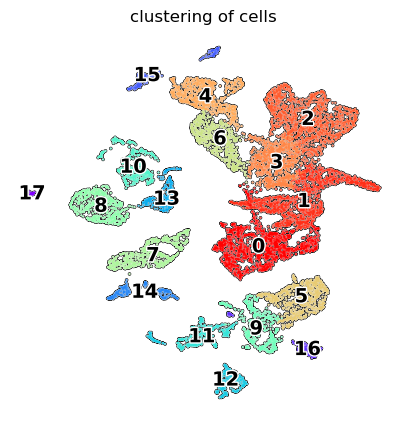

In [49]:
from matplotlib.pyplot import rc_context
import scanpy as sc
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.umap(sc_decode.adata, color='leiden', add_outline=True, legend_loc='on data',
               legend_fontsize=14, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='rainbow_r')

In [33]:
sc_decode.adata.obsm['X_umap']

array([[ 0.9366996,  8.567746 ],
       [-4.53089  ,  4.3682613],
       [-1.7996038,  8.250262 ],
       ...,
       [ 6.441952 , -5.2568064],
       [14.326158 ,  9.413409 ],
       [12.595271 , 14.184902 ]], dtype=float32)

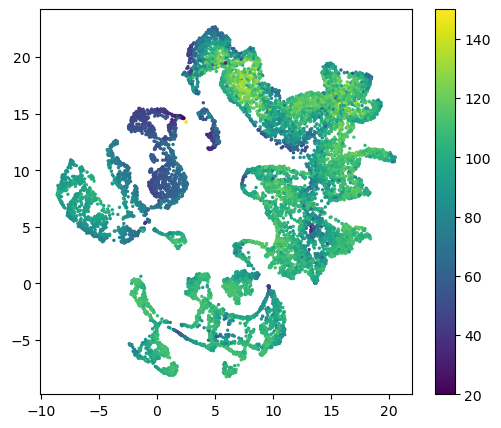

In [34]:
plt.figure(figsize=(6,5))
plt.scatter(sc_decode.adata.obsm['X_umap'][:,0],sc_decode.adata.obsm['X_umap'][:,1],
            c=sc_decode.intens_mtx.astype(bool).sum(1),s=2,vmax=150,rasterized=True)
plt.colorbar()
#plt.savefig('../figures/sc_decoded_umap_num_lipid.pdf',dpi=300)

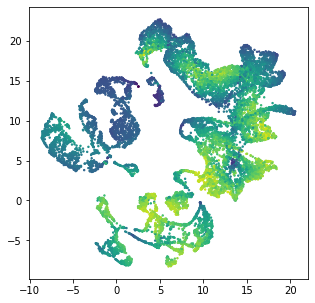

In [432]:
plt.figure(figsize=(5,5))
plt.scatter(sc_decode.adata.obsm['X_umap'][:,0],sc_decode.adata.obsm['X_umap'][:,1],
            c=sc_decode.intens_mtx.sum(1),s=2,vmin=0)


In [96]:
plt.savefig('../figures/sc_decoded_umap_tiss_leiden.pdf')

<Figure size 432x288 with 0 Axes>

In [294]:
label = 'types'
show_feat = widgets.interactive(sc_decode.show_featrank, label = label, region = sc_decode.label_class[label], 
                                rank_by=sc_decode.feat_rank[label].keys(), num_select=8000,
                                num_show=IntSlider(min=0, max=8000, step=20, value=0));

show_feat

interactive(children=(Text(value='types', description='label'), Dropdown(description='region', options=('Corpu…

In [420]:
sm_feat

364     659.3912
365     659.3912
366     659.3912
1036    831.5724
1084    853.5928
1085    853.5928
1120    863.6177
1130    865.6306
1161    883.6404
1162    883.6404
1181    901.5974
1182    901.5974
1203    911.6718
1204    911.6718
Name: Input m/z, dtype: object

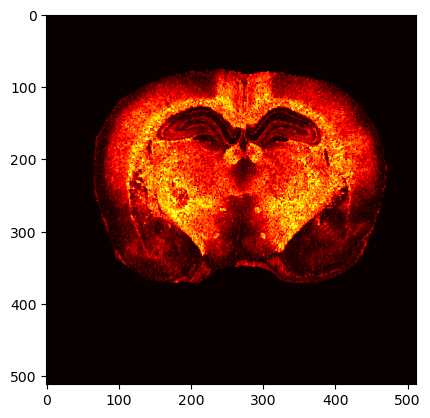

In [435]:
img = reg.IonImg_transform(tiss_decode.intens_mtx['863.6177'],
                           reg.transform[slice_order[9]],True).T
plt.imshow(img,'hot')
plt.savefig('../figures/coronal_863mz.pdf')

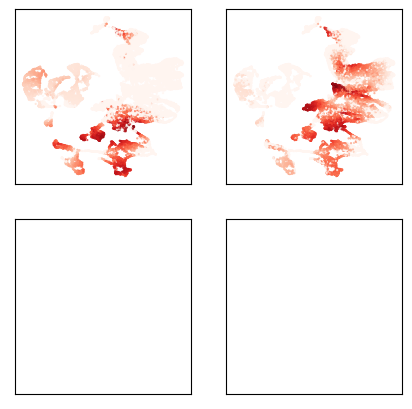

In [436]:
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax = axes.ravel()
embedding = sc_decode.adata.obsm['X_umap']
features_show = ['707.4966','863.6177']
for i,feature in enumerate(features_show):
    ax[i].scatter(embedding[:,0],embedding[:,1], s=0.3, c=sc_decode.intens_mtx[feature], cmap='Reds', alpha=0.8,vmin=0,rasterized=True)
    plt.setp(ax, xticks=[], yticks=[])
plt.savefig('../figures/sc_umap_dist_cor_corp_top_2.pdf',dpi=300)


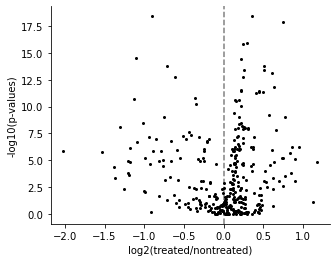

In [375]:
fig,axes = plt.subplots(1,1,figsize=(5,4))
axes.scatter(show_feat.result['logfoldchanges'],show_feat.result['pvals_adj'],s=4,c='k',edgecolors='k')
axes.axvline(0,linestyle='--',c='k',alpha=0.5)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('log2(treated/nontreated)')
plt.ylabel('-log10(p-values)')
#plt.xlim([-4,3])
#plt.show()
#plt.savefig('../figures/volcano_sc_tha.pdf')

In [30]:
def show_featdist(features, embed_method, size, vmin=0):

    embedding = sc_decode.adata.obsm[embed_method]

    #plt.close()
    fig, ax = plt.subplots(1, figsize=(5, 4))

    plt.scatter(embedding[:,0],embedding[:,1], s=size, c=sc_decode.intens_mtx[features], cmap='Reds', alpha=1,vmin=vmin)
    plt.setp(ax, xticks=[], yticks=[])
    plt.colorbar()

In [67]:
features_show = ['496.3423','784.5894','594.3791','737.5831','721.0084','955.5929','928.5647','744.4165','809.5855','766.4616','863.6177',
'690.4744','674.4402','660.4643','725.4519','737.5078','508.3773','564.3652','707.4966','704.5229','865.6306','853.5928',
'909.6611','701.3976','580.9249']
show_featdist = widgets.interactive(sc_decode.show_featdist, features=features_show,
                                 embed_method=sc_decode.adata.obsm.keys(),size=(0.5,2,0.1));
show_featdist

interactive(children=(Dropdown(description='features', options=('496.3423', '784.5894', '594.3791', '737.5831'…

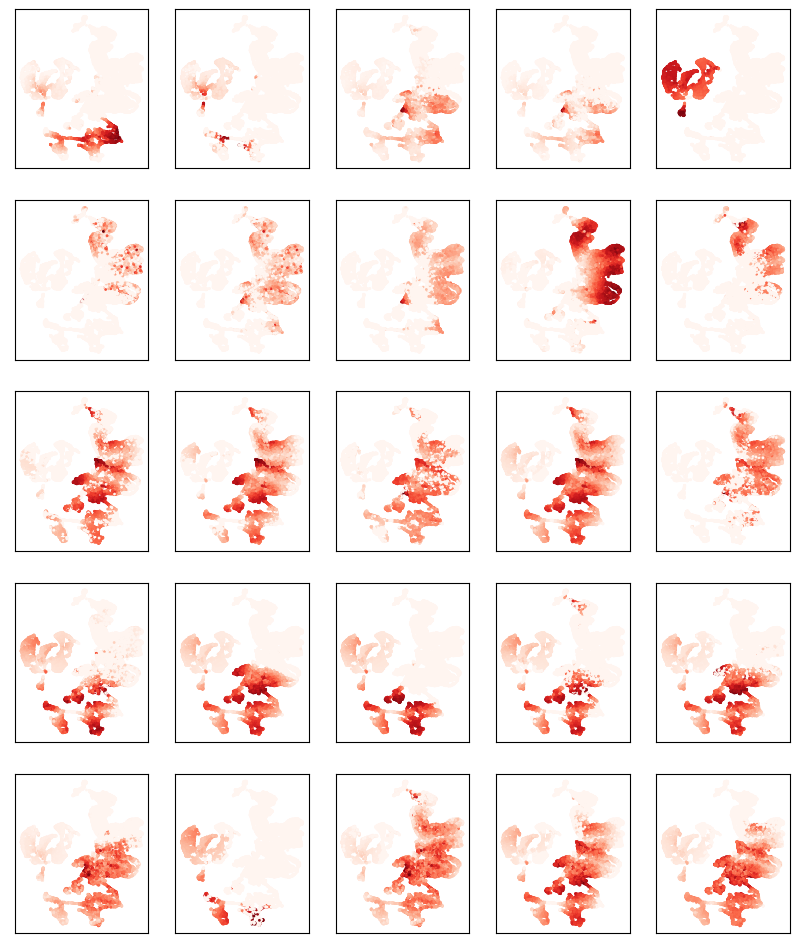

In [70]:
fig, axes = plt.subplots(5,5, figsize=(10, 12))
ax = axes.ravel()
embedding = sc_decode.adata.obsm['X_umap']
for i,feature in enumerate(features_show):
    ax[i].scatter(embedding[:,0],embedding[:,1], s=1, c=sc_decode.intens_mtx[feature], cmap='Reds', alpha=1,vmin=0,rasterized=True)
    plt.setp(ax, xticks=[], yticks=[])
plt.savefig('../figures/sc_umap_dist_top25.pdf',dpi=300)


categories: 0, 1, 2, etc.
var_group_labels: cortex


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


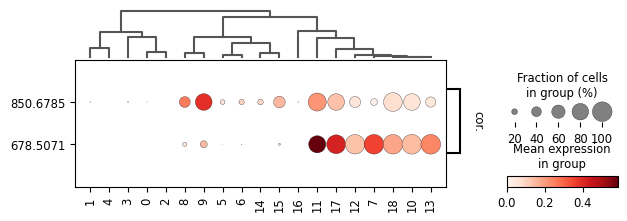

In [252]:
#features_dict = {'cortex':['955.5929','870.4586']}
features_dict = {'cortex':['850.6785','678.5071']}
sc.pl.dotplot(sc_decode.adata, features_dict, 'leiden', dendrogram=True,swap_axes=True,figsize=(7,2),save='sc_corp_specific_dot.pdf')


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


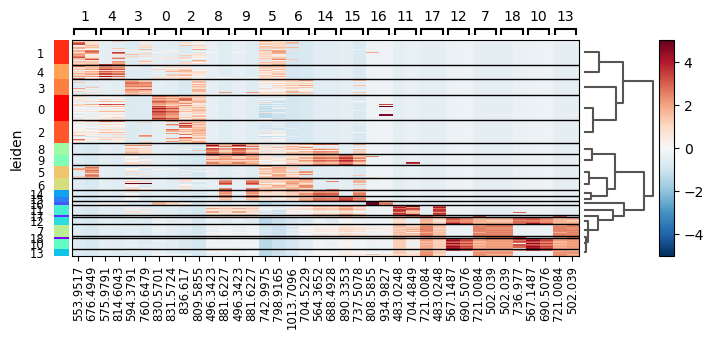

In [84]:
sc_decode.adata.layers['scaled'] = sc.pp.scale(sc_decode.adata, copy=True, zero_center=True).X
sc.pl.rank_genes_groups_heatmap(sc_decode.adata,n_genes=2,
              groupby='leiden',swap_axes=False,dendrogram=True,layer='scaled',cmap='RdBu_r',vmax=5,vmin=-5,figsize=(8,3),save='sc_regional_top2.pdf')


In [126]:
sc.get.rank_genes_groups_df(sc_decode.adata, group=['13'])

,names,scores,logfoldchanges,pvals,pvals_adj
0,721.0084,31.051125,7.708085,1.101640e-211,3.789642e-209
1,502.039,30.793230,6.970278,3.228613e-208,5.553214e-206
2,494.36,29.336792,2.668536,3.522287e-189,4.038889e-187
3,681.4814,29.063137,3.746061,1.050057e-185,7.224393e-184
4,784.5894,28.642456,2.865373,1.990258e-180,1.141081e-178
...,...,...,...,...,...
339,847.6267,-26.398720,-9.382965,1.417348e-153,3.750520e-152
340,910.6659,-27.086891,-4.067388,1.405144e-161,4.394269e-160
341,702.5095,-28.258394,-7.227150,1.122460e-175,4.826576e-174
342,594.4148,-28.372644,-4.941790,4.400205e-177,2.162387e-175


In [437]:
mzs = np.load('../processed_data/coronal3d_mz.npy')
adducts = ['M+H','M+Na','M+K']
site_url = 'https://www.lipidmaps.org/rest/moverz/LIPIDS'

annot_df, matched, unmatched = LipidMaps_annotate([707.4966,863.6177], adducts, 3, site_url)

  0%|                                                     | 0/2 [00:00<?, ?it/s]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.91s/it]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be 

In [398]:
#annot_df.to_pickle('../processed_data/tiss_sc_lipidmap_annot.pkl')
annot_df = pd.read_pickle('../processed_data/tiss_sc_lipidmap_annot.pkl')

In [83]:
annot_df.to_csv('../top5_regional_sc_tiss.csv')

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


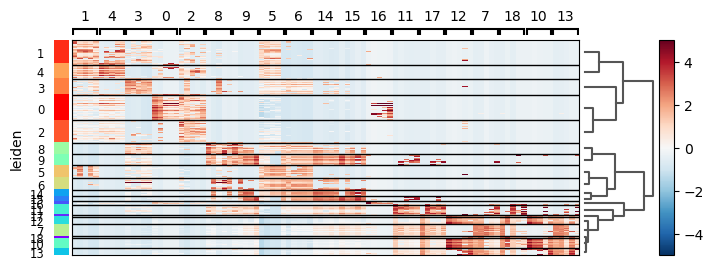

In [71]:
sc_decode.adata.layers['scaled'] = sc.pp.scale(sc_decode.adata, copy=True, zero_center=True).X
sc.pl.rank_genes_groups_heatmap(sc_decode.adata,n_genes=5,
              groupby='leiden',swap_axes=False,dendrogram=True,layer='scaled',cmap='RdBu_r',vmax=5,vmin=-5,figsize=(8,3),save='sc_regional_top25.pdf')


In [400]:
annot_df['Input m/z'] = annot_df['Input m/z'].round(4).astype(str)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Corpus'),
  Text(1, 0, 'Cortex'),
  Text(2, 0, 'Hip'),
  Text(3, 0, 'Striatum'),
  Text(4, 0, 'Thalamus')])

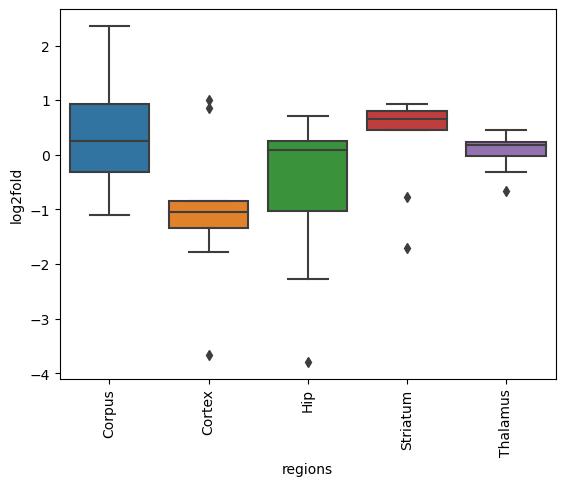

In [401]:
sm_feat = annot_df[(annot_df['Name'].str.contains('SM'))&(annot_df['Ion'].str.contains('H'))]['Input m/z']
sm_log2fold = []
sm_regions = []
regions = metadata['types']
for region in regions.unique():
    treated_data = sc_decode.intens_mtx[sm_feat].iloc[np.array(regions)==region].values
    nontreated_data = sc_decode.intens_mtx[sm_feat].iloc[np.array(regions)!=region].values
    treated_mean = treated_data.mean(0)
    nontreated_mean = nontreated_data.mean(0)
    log2fold = np.log2(treated_mean/nontreated_mean)
    sm_log2fold+=list(log2fold)
    sm_regions+=[region]*log2fold.shape[0]
    
sns.boxplot(data=pd.DataFrame({'log2fold':sm_log2fold,'regions':sm_regions}),x='regions',y='log2fold')
plt.xticks(rotation=90)
#plt.savefig('../figures/sm_sc_tiss.pdf')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Corpus'),
  Text(1, 0, 'Cortex'),
  Text(2, 0, 'Hip'),
  Text(3, 0, 'Striatum'),
  Text(4, 0, 'Thalamus')])

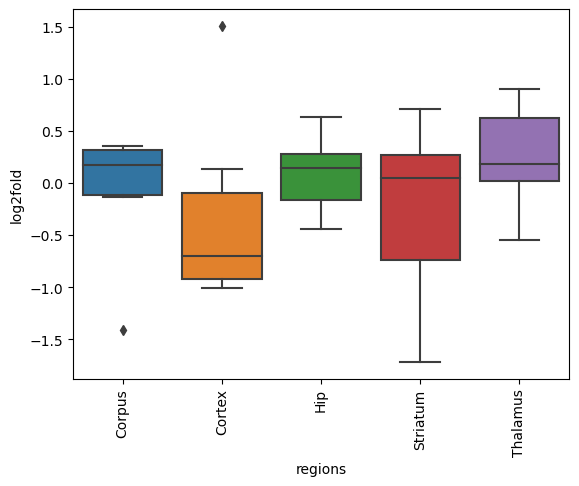

In [419]:
sm_feat = annot_df[(annot_df['Name'].str.contains('PG'))&(annot_df['Ion'].str.contains('H'))]['Input m/z']
sm_log2fold = []
sm_regions = []
regions = metadata['types']
for region in regions.unique():
    treated_data = sc_decode.intens_mtx[sm_feat].iloc[np.array(regions)==region].values
    nontreated_data = sc_decode.intens_mtx[sm_feat].iloc[np.array(regions)!=region].values
    treated_mean = treated_data.mean(0)
    nontreated_mean = nontreated_data.mean(0)
    log2fold = np.log2(treated_mean/nontreated_mean)
    sm_log2fold+=list(log2fold)
    sm_regions+=[region]*log2fold.shape[0]
    
sns.boxplot(data=pd.DataFrame({'log2fold':sm_log2fold,'regions':sm_regions}),x='regions',y='log2fold')
plt.xticks(rotation=90)
#plt.savefig('../figures/pg_sc_tiss.pdf')

In [67]:
from sklearn.decomposition import TruncatedSVD, NMF

def get_sc_basis(data,labels,k):
    unique_labels = set(labels)
    labels = np.array(labels)
    basis = {}
    
    for label in unique_labels:
        d = data[labels==label]
        decom = TruncatedSVD(k)
        decom.fit(d)
        Vt = decom.components_
        basis[label] = Vt
        
    return basis

def get_sc_basis_nmf(data,labels,k):
    
    unique_labels = set(labels)
    labels = np.array(labels)
    basis = {}
    print(unique_labels)
    for label in unique_labels:
        d = data[labels==label]
        decom = NMF(k,max_iter=3000)
        decom.fit(d)
        Vt = decom.components_
        basis[label] = Vt
        print(label)
    return basis

In [68]:
idx = sc_decode.intens_mtx[(sc_decode.intens_mtx<0).sum(1)==0].index
#sc_basis = get_sc_basis(sc_decode.intens_mtx,list(sc_decode.metadata['leiden']),20)
sc_basis_nmf = get_sc_basis_nmf(sc_decode.intens_mtx.loc[idx],list(sc_decode.metadata.loc[idx]['leiden']),20)

{'5', '21', '14', '11', '9', '17', '4', '15', '16', '12', '2', '18', '8', '20', '6', '13', '10', '1', '7', '19', '3', '0'}


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


5
21


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


14


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


11


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


9


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


17
4


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


15


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


16


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


12


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


2


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


18


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


8


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


20


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


6


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


13
10
1


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


7


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


19
3
0


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


In [69]:
clusters = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
basis_values = []
for i in range(len(clusters)):
    basis_values.append(sc_basis_nmf[clusters[i]])
basis_values = np.concatenate(basis_values)

In [70]:
clusters[int(140/20)]

'7'

In [71]:
basis_values = basis_values/basis_values.max(0)
basis_values = basis_values/basis_values.max(1).reshape(-1,1)

In [32]:
rank = basis_values[:20].mean(0).argsort()[::-1]

KeyboardInterrupt: 

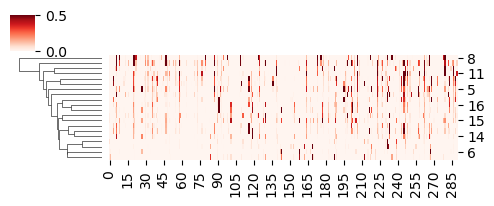

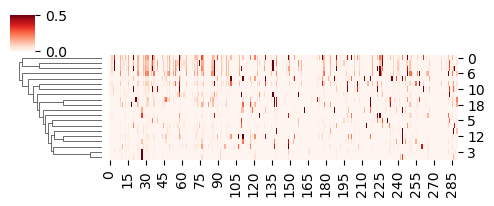

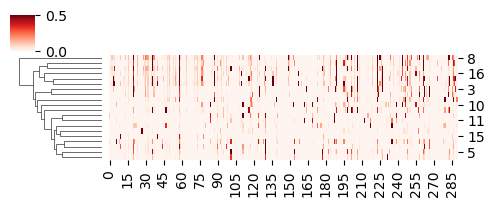

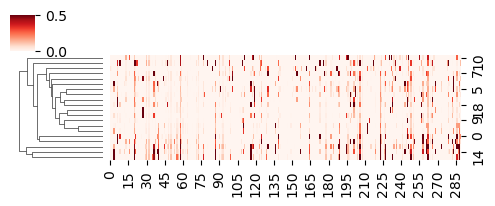

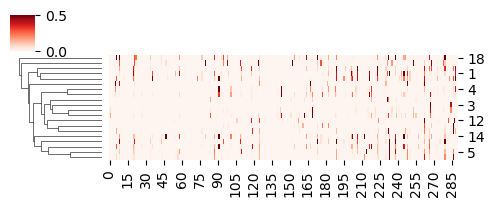

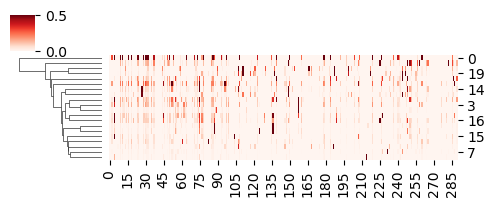

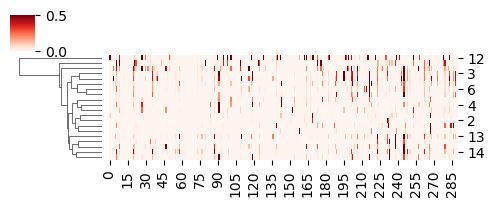

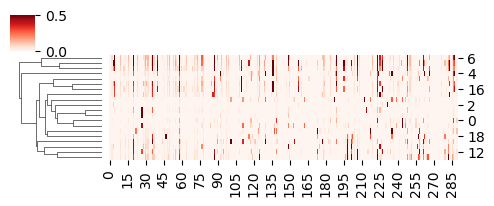

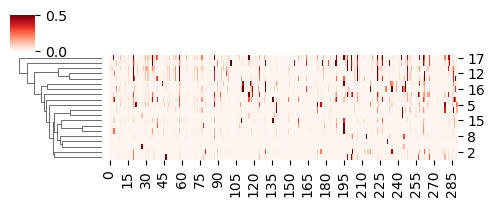

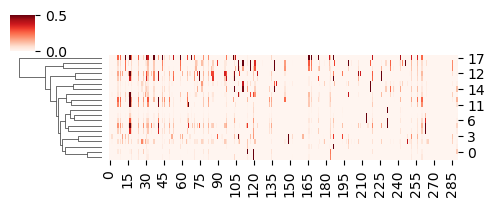

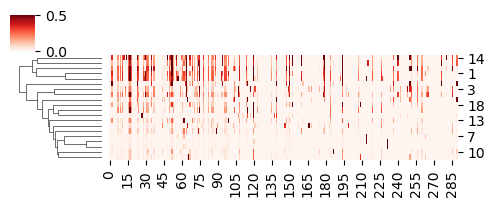

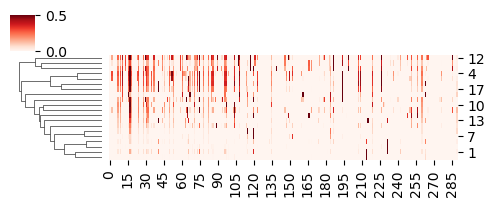

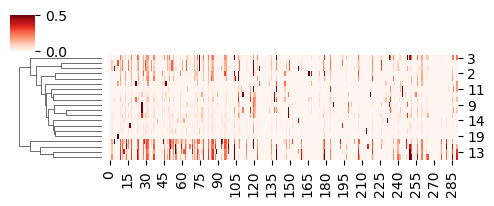

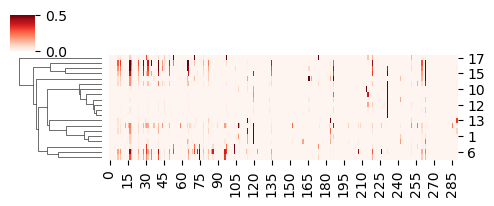

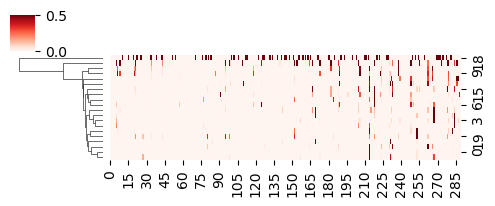

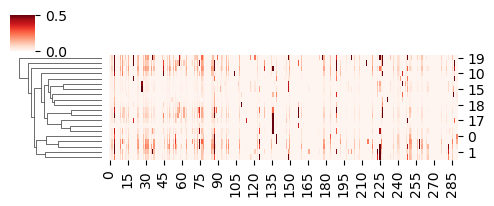

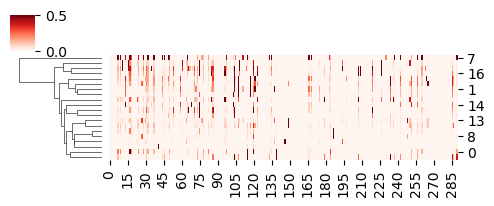

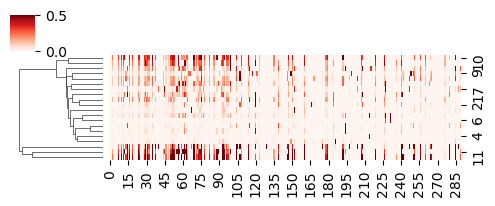

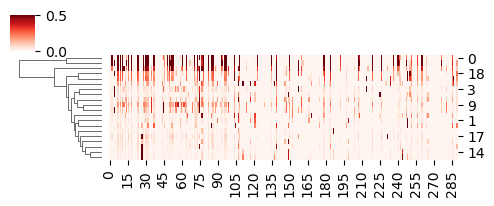

In [33]:
for i,cluster in enumerate(clusters):
    sns.clustermap(basis_values[20*i:20*i+20],cmap='Reds',col_cluster=False,figsize=(5,2),vmax=0.5)
    plt.savefig('../figures/sc_basis_cluster_{}.pdf'.format(i))

In [34]:
from sklearn.linear_model import LinearRegression

def fit_tiss_sc_basis(data, basis, positive):
    label_names = list(basis.keys())
    basis = np.concatenate(list(basis.values()))
    
    coef = []
    
    for i in tqdm(range(0,data.shape[0],128)):
        reg = LinearRegression(positive=positive,n_jobs=8)
        reg.fit(basis.T, data[i:i+128].T)
        coef.append(reg.coef_)
        
    return np.concatenate(coef),label_names

def get_residual(data, basis, coef):
    return data - np.matmul(coef,np.concatenate(list(basis.values())))

In [72]:
np.concatenate(list(sc_basis_nmf.values())).shape

(440, 259)

In [73]:
coef,_ = fit_tiss_sc_basis(tiss_decode.intens_mtx.values, sc_basis_nmf, True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:51<00:00,  6.10it/s]


In [74]:
residual = get_residual(tiss_decode.intens_mtx.values, sc_basis_nmf, coef[0])

In [75]:
res = tiss_decode.intens_mtx.values-np.matmul(coef,np.concatenate(list(sc_basis_nmf.values())))

In [83]:
basis_labels = []
for i in sc_basis_nmf.keys():
    basis_labels+=20*[i]

In [84]:
sc_fitted = np.matmul(coef,np.concatenate(list(sc_basis_nmf.values())))

In [363]:
# for i in range(tiss_decode.intens_mtx.shape[1]):
#     plt.plot((tiss_decode.intens_mtx.columns.astype(float)[i],tiss_decode.intens_mtx.columns.astype(float)[i]),
#              (0,tiss_decode.intens_mtx.values[58][i]),c='k')
#     plt.plot((tiss_decode.intens_mtx.columns.astype(float)[i],tiss_decode.intens_mtx.columns.astype(float)[i]),
#              (0,sc_fitted[58][i]),c='salmon')

In [171]:
from scipy.stats import pearsonr
fit_corr = []
for i in tqdm(range(tiss_decode.intens_mtx.shape[0])):
    fit_corr.append(pearsonr(sc_fitted[i],
                             tiss_decode.intens_mtx.values[i])[0])
fit_corr = np.array(fit_corr)

100%|██████████████████████████████████| 44496/44496 [00:01<00:00, 22514.95it/s]


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


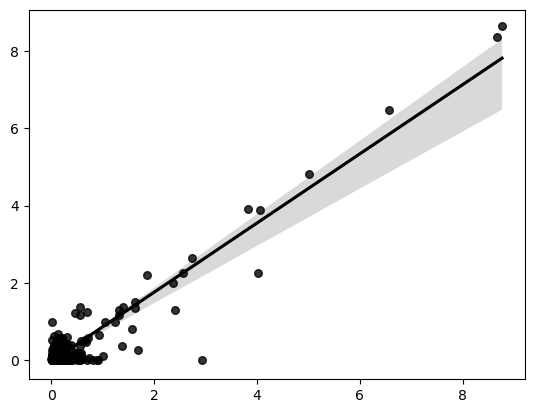

In [426]:
sns.regplot(tiss_decode.intens_mtx.values[58],sc_fitted[58],color='k',scatter_kws={'s':30},marker='o')
plt.savefig('../figures/sc_fit_tiss_scatter.pdf')

In [427]:
pearsonr(sc_fitted[58],tiss_decode.intens_mtx.values[58])

(0.9465483689477963, 4.017851819026564e-170)

In [243]:
corr_regions = []
regions = []
for key in atlas_region.keys():
    region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1))))
    corr = fit_corr[region_idx[region_idx>=0]]
    corr_regions.append(corr)
    regions+=[key]*corr.shape[0]
    

In [272]:
from scipy.stats import pearsonr
spat_corr = []
for i in tqdm(range(tiss_decode.intens_mtx.shape[1])):
    spat_corr.append(pearsonr(sc_fitted[:,i],
                             tiss_decode.intens_mtx.values[:,i])[0])
spat_corr = np.array(spat_corr)

100%|████████████████████████████████████████| 344/344 [00:00<00:00, 406.20it/s]


In [283]:
spat_corr_df = pd.DataFrame({'corr':spat_corr,'mean intensity':np.log10(tiss_decode.intens_mtx.mean(0).values)})
spat_corr_df.loc[spat_corr_df['mean intensity']<-1.2,'range'] = '<-1.2'
spat_corr_df.loc[(spat_corr_df['mean intensity']>-1.2)&(spat_corr_df['mean intensity']<-0.5),'range'] = '-0.5 to -1.2'
spat_corr_df.loc[(spat_corr_df['mean intensity']>-0.5)&(spat_corr_df['mean intensity']<0),'range'] = '0 to -0.5'
spat_corr_df.loc[(spat_corr_df['mean intensity']>0),'range'] = '>0'

#plt.scatter(spat_corr,np.log10(tiss_decode.intens_mtx.mean(0)))

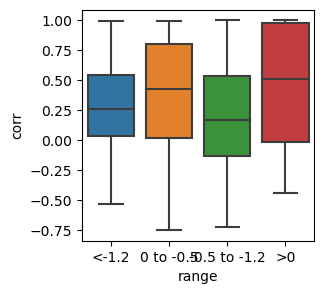

In [367]:
plt.figure(figsize=(3,3))
sns.boxplot(x='range',y='corr',data=spat_corr_df)
plt.savefig('../figures/spat_corr_sc_fit_tiss.pdf')

In [268]:
import image_registration
#file_dir = '../processed_data/coronal3D_propagated_decoded.h5'
file_dir = '/Volumes/Housecats2/3DCoronal/decoded_data_new/coronal3D_propagated_decoded_new.h5'
reg = image_registration.Image(data_dir=file_dir,registration_dir='../image_transform',group_order=slice_order)
reg.load_transform('../image_register/Matlab Registration/coronal_registration')
#reg.load_data(True)

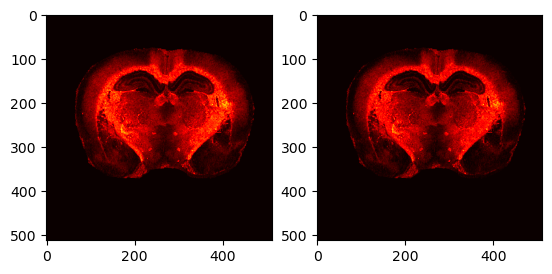

In [478]:
img = reg.IonImg_transform(tiss_decode.intens_mtx.values[:,284],
                           reg.transform[slice_order[9]],True).T
img_fitted = reg.IonImg_transform(sc_fitted[:,284],
                           reg.transform[slice_order[9]],True).T
plt.subplot(1,2,1)
plt.imshow(img,'hot')
plt.subplot(1,2,2)
plt.imshow(img_fitted,'hot')
plt.savefig('../figures/spat_img_fitted_284.pdf',dpi=300)

In [470]:
pearsonr(tiss_decode.intens_mtx.values[:,284],sc_fitted[:,284])

(0.996488718302247, 0.0)

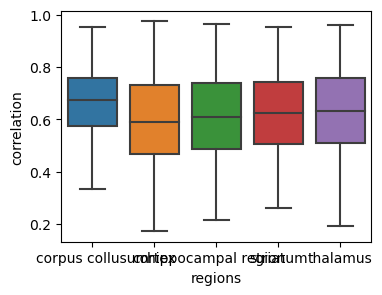

In [368]:
df = pd.DataFrame({'correlation':np.concatenate(corr_regions),'regions':regions})
# g = sns.FacetGrid(df, row="regions",height=1, aspect=3)
# g.map_dataframe(sns.histplot,stat='proportion',bins=30,kind="ecdf")
plt.figure(figsize=(4,3))
sns.boxplot(x='regions',y='correlation',data=df)
plt.savefig('../figures/spec_corr_sc_fit_tiss.pdf')

In [62]:
np.linalg.norm(residual,axis=1).min()

5.440517677478879

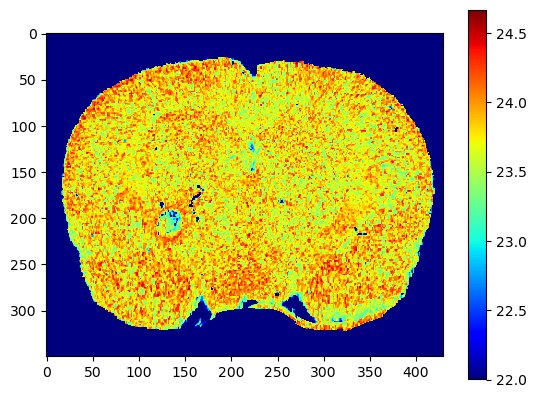

In [60]:
plt.figure()
img = IonImg_transform(np.linalg.norm(residual,axis=1),spec_idx_transform, True).T[50:400,50:480]
plt.imshow(img,cmap='jet',vmin=22)
plt.colorbar()

In [38]:
def IonImg_transform(data, spec_idx_transform, background):
    if background:
        ion_img_transform = np.zeros(spec_idx_transform.size)
    else:
        ion_img_transform = np.empty(spec_idx_transform.size)
        ion_img_transform[:] = np.nan
    img_shape = spec_idx_transform.shape
    spec_idx_transform_flatten = spec_idx_transform.flatten()
    ion_img_transform[spec_idx_transform_flatten!=0] = data[spec_idx_transform_flatten[spec_idx_transform_flatten!=0]-1]
    ion_img_transform = ion_img_transform.reshape(img_shape)
    return ion_img_transform

In [2]:
spec_idx_transform = spec_idx_transformed[:,:,slice_no]
fig,axes = plt.subplots(4,6,figsize=(20,10))
ax = axes.ravel()
idx = 0
for i in range(0,coef.shape[1],20):
    img = IonImg_transform(np.linalg.norm(coef[:,i:i+20],axis=1),spec_idx_transform, False).T[50:400,50:480]
    ax[idx].imshow(img,cmap='jet',vmax=0.55*np.linalg.norm(coef[:,i:i+20],axis=1).max(),interpolation='gaussian')
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(list(sc_basis_nmf.keys())[idx])
    idx += 1
fig.tight_layout()
fig.savefig('../figures/coef_cluster_2.pdf',dpi=300)

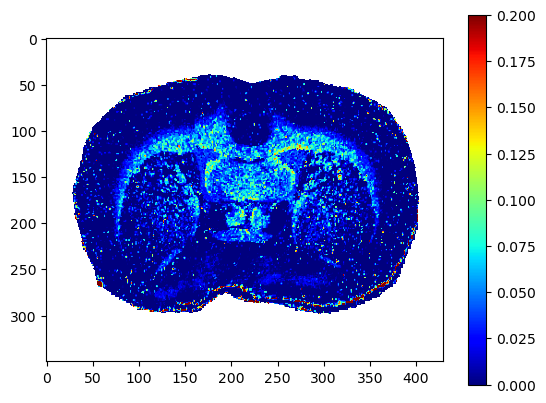

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [89]:
img = IonImg_transform(np.linalg.norm(coef[:,300:320],axis=1),spec_idx_transform, False).T[50:400,50:480]
plt.imshow(img,cmap='jet',vmax=0.2)
plt.colorbar()
plt.savefig('../figures/coef_cluster6_3.pdf',dpi=300)

In [49]:
len(fit_corr)

44496

In [531]:
coef_umap = umap.UMAP().fit(coef)

In [91]:
idx = sc_decode.intens_mtx[(sc_decode.intens_mtx<0).sum(1)==0].index
sc_basis_nmf_type = get_sc_basis_nmf(sc_decode.intens_mtx.loc[idx],list(sc_decode.metadata['types'].loc[idx]),20)

{'Corpus', 'Hip', 'Cortex', 'Striatum', 'Thalamus'}
Corpus
Hip
Cortex
Striatum
Thalamus


In [92]:
coef_type,basis_names = fit_tiss_sc_basis(tiss_decode.intens_mtx.values, sc_basis_nmf_type, True)

100%|█████████████████████████████████████████| 348/348 [00:11<00:00, 29.36it/s]


In [93]:
basis_names

['Corpus', 'Hip', 'Cortex', 'Striatum', 'Thalamus']

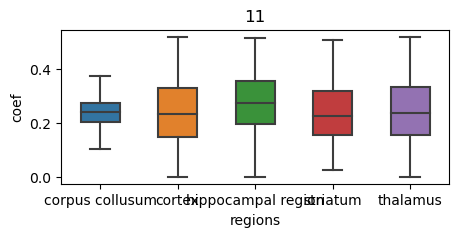

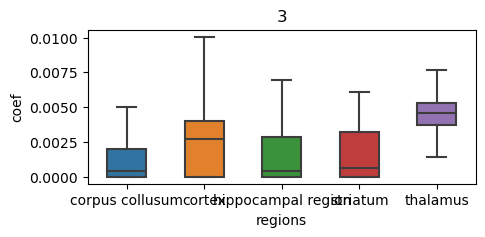

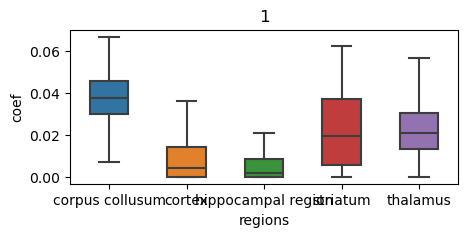

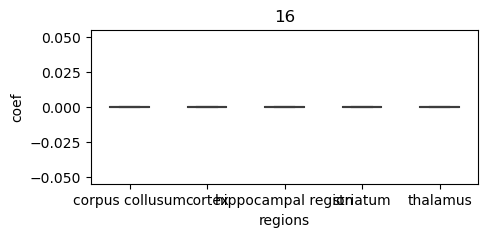

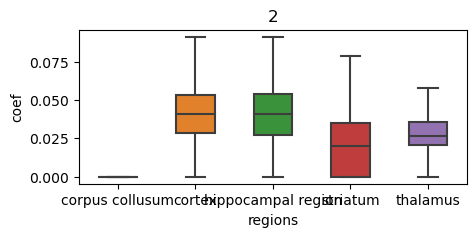

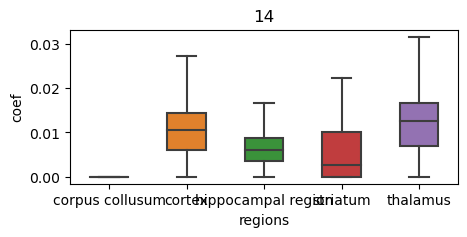

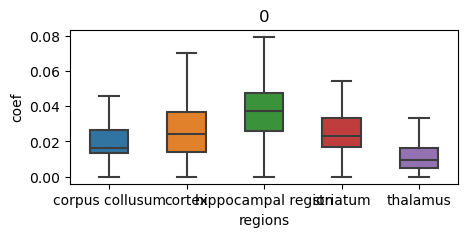

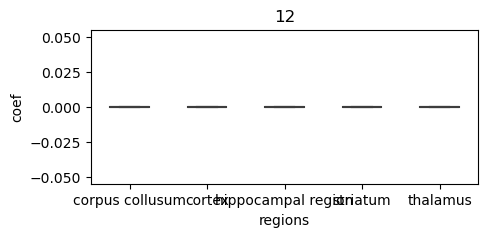

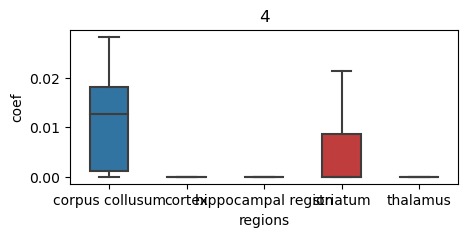

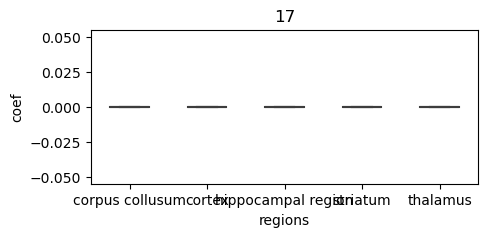

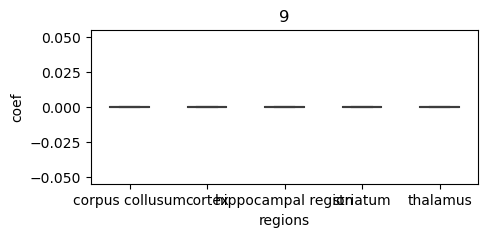

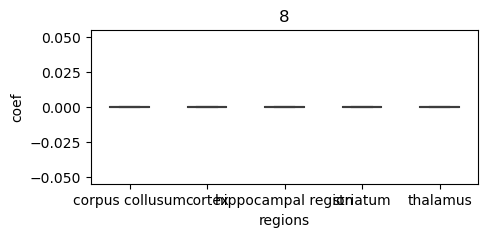

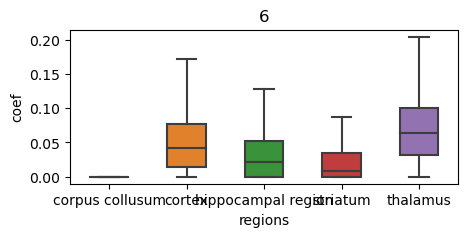

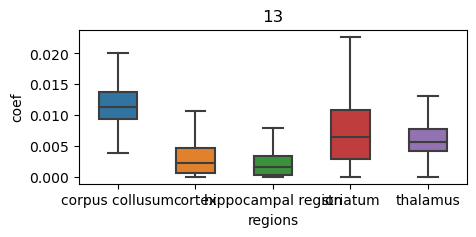

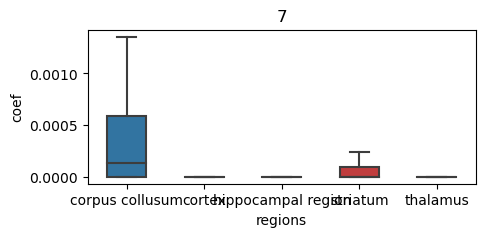

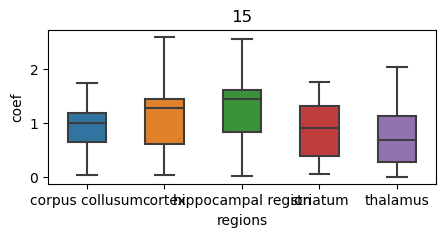

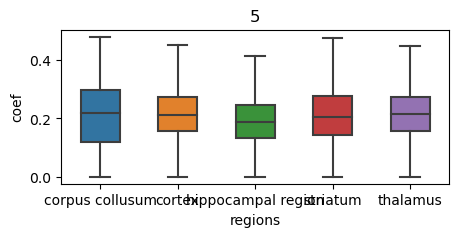

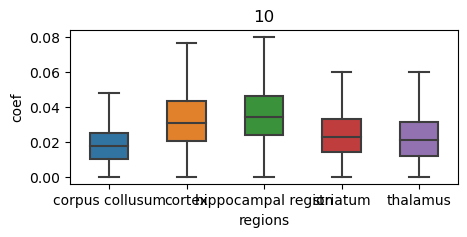

In [161]:
slice_no = 9
atlas_region = {'corpus collusum':67,'cortex':92,'hippocampal region':[95,96,97,98],'striatum':30,'thalamus':39}
idx = 0
coef_regions = []
corr_regions = []
for i in range(0,coef.shape[1],20):
    regions = []
    data = []
    for key in atlas_region.keys():
        region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1))))
        region_coef = coef[region_idx[region_idx>=0],i:i+20]
        data.append(np.linalg.norm(region_coef,axis=1))
        regions+=[key]*region_coef.shape[0]
    df = pd.DataFrame({'coef':np.concatenate(data),'regions':regions})
    plt.figure(figsize=(5,2))
    sns.boxplot(x='regions',y='coef',data=df,showfliers=False,width=0.5)
    coef_avg = np.array([d.mean() for d in data])
    if coef_avg.max()!=0:
        coef_regions.append(coef_avg/coef_avg.max())
    else:
        coef_regions.append(coef_avg)
    plt.title(list(sc_basis_nmf.keys())[idx])
    #plt.savefig('../figures/coef_dist_cluster_{}.pdf'.format(list(sc_basis_nmf.keys())[idx]))
    plt.show()
    idx+=1

In [162]:
coef_regions = pd.DataFrame(np.array(coef_regions),index=list(sc_basis_nmf.keys()),columns=atlas_region.keys())

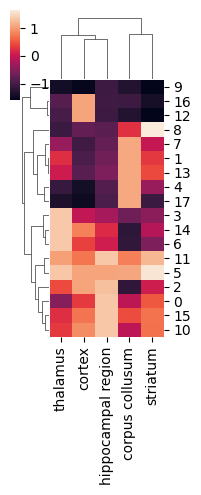

In [370]:
clustergrid = sns.clustermap(coef_regions,figsize=(2,5),z_score=1)
plt.savefig('../figures/coef_regions.pdf')

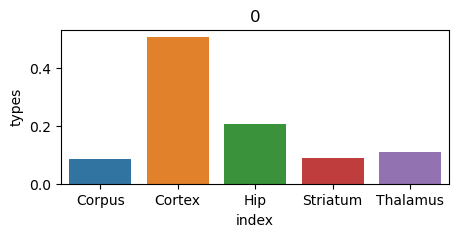

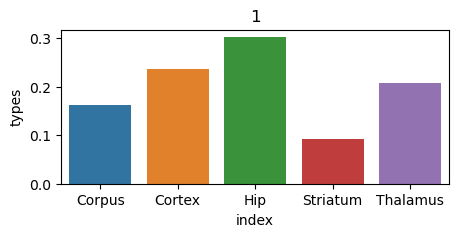

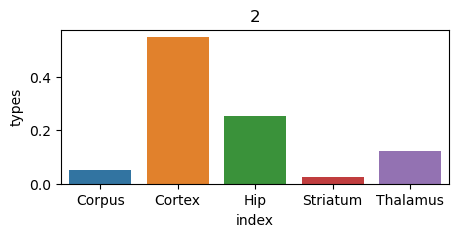

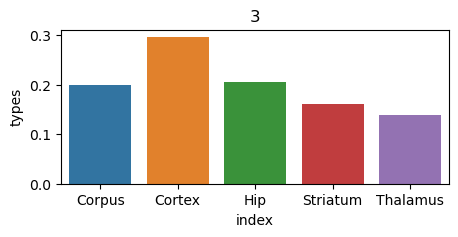

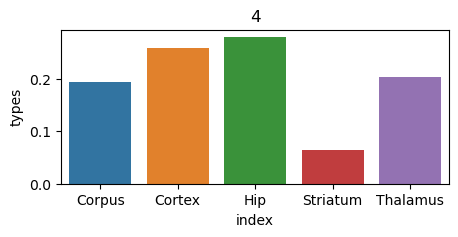

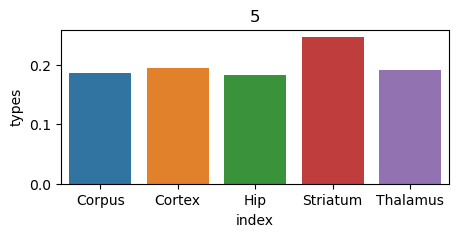

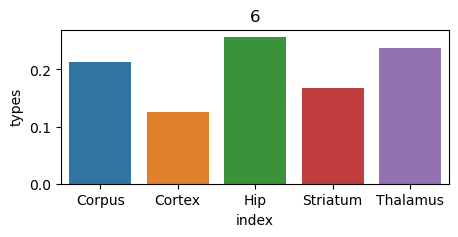

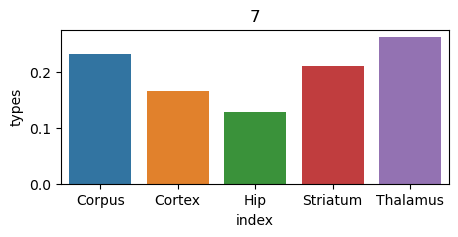

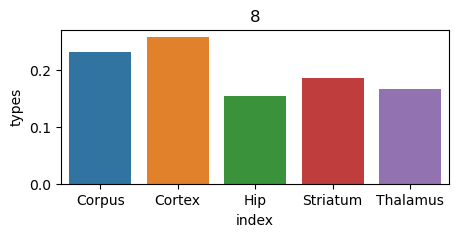

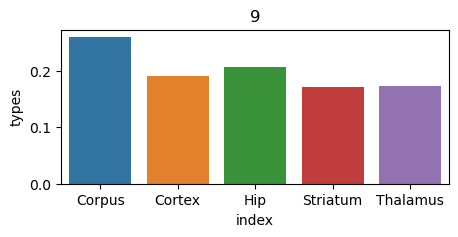

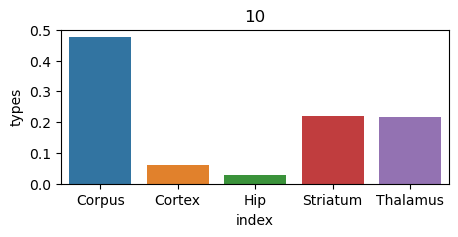

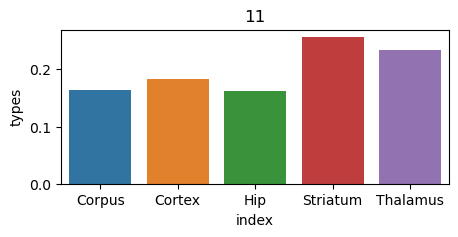

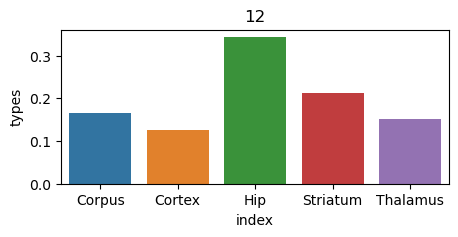

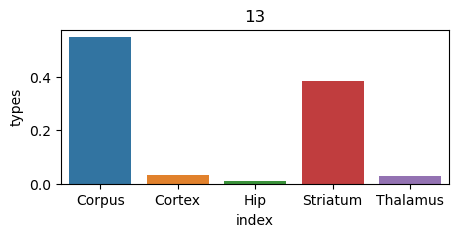

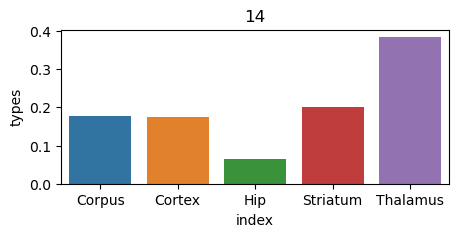

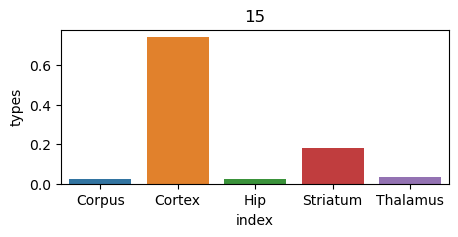

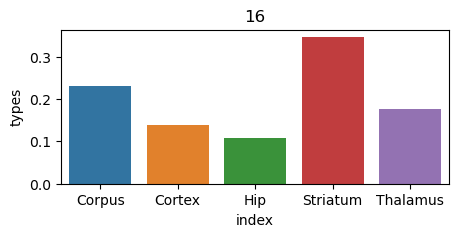

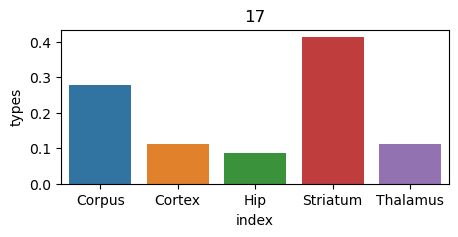

In [428]:
for i,cluster in enumerate(clusters):
    counts = sc_decode.metadata[sc_decode.metadata['leiden']==cluster]['types'].value_counts(sort=False)
    plt.figure(figsize=(5,2))
    sns.barplot(data=pd.DataFrame(counts/counts.sum()).reset_index(),x='index',y='types',
                order=['Corpus','Cortex','Hip','Striatum','Thalamus'])
    plt.title(cluster)
    plt.savefig('../figures/cell_perc_dist_cluster_{}.pdf'.format(cluster))

In [143]:
average_spec_region = pd.read_pickle('../processed_data/average_spec_region.pkl')
average_spec_region_metadata = pd.read_pickle('../processed_data/metadata_average_spec_region.pkl')

In [144]:
average_spec_region_metadata

,regions,slices,matter
0,basal forebrain,slide1_2_R00,mixed
1,corpus collusum,slide1_2_R00,white
2,cortex,slide1_2_R00,grey
3,hippocampal region,slide1_2_R00,grey
4,striatum,slide1_2_R00,mixed
...,...,...,...
158,corticofugal pathway,slide3_5_R05,white
159,hippocampal region,slide3_5_R05,grey
160,thalamus,slide3_5_R05,grey
161,brainstem,slide3_5_R05,mixed


In [145]:
select = average_spec_region_metadata['regions'].isin(['cortex','thalamus','hippocampal region','striatum','corpus collusum'])


In [146]:
avg_region  = scMSAnalysis(average_spec_region_metadata.loc[select])
avg_region.preprocessing(average_spec_region.loc[select], norm_method='None',feat_drop_rate=0.005,cell_drop_rate=0.005)

filtered intensity matrix with shape (94, 1156)


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [147]:
avg_region.get_labels(['regions','slices','matter'])
avg_region.analyze(n_neighbors=25, n_pcs=20, min_dist=0.5, resolution = 0.15,
              categories=['regions','matter'])

computing neighbors..
performing umap...


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'regions' as categorical
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'slices' as categorical
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a f

performing clustering...


In [199]:
annot_df[annot_df['Input m/z']=='678.5071']

,Input m/z,Matched m/z,Delta,Name,Formula,Ion


In [200]:
annot_df

,Input m/z,Matched m/z,Delta,Name,Formula,Ion
0,413.303607,413.3026,0.0010,FA 25:4;O,C25H42O3Na,[M+Na]+
1,413.303607,413.3026,0.0010,MG O-22:5,C25H42O3Na,[M+Na]+
2,413.303607,413.3026,0.0010,ST 25:1;O3,C25H42O3Na,[M+Na]+
3,413.303607,413.3028,0.0008,MG O-19:0;O,C22H46O4K,[M+K]+
4,415.284752,415.2843,0.0005,FA 26:7;O2,C26H39O4,[M+H]+
...,...,...,...,...,...,...
1263,1044.775874,1044.7756,0.0003,PE O-58:10,C63H108NO7PNa,[M+Na]+
1264,1044.775874,1044.7757,0.0002,PC 52:4,C60H112NO8PK,[M+K]+
1265,1044.775874,1044.7757,0.0002,PC O-52:5;O,C60H112NO8PK,[M+K]+
1266,1044.775874,1044.7757,0.0002,PE 55:4,C60H112NO8PK,[M+K]+


In [185]:
show_feat.result['feature names'][21]

'678.5071'

categories: corpus collusum, cortex, hippocampal region, etc.
var_group_labels: corpus


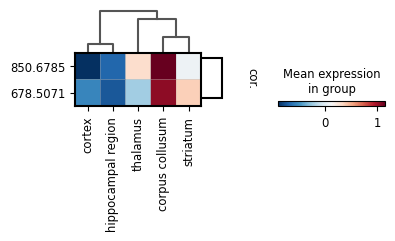

In [251]:
avg_region.adata.layers['scaled'] = sc.pp.scale(avg_region.adata, copy=True).X
mapping = {'corpus':['850.6785','678.5071']}
sc.pl.matrixplot(avg_region.adata, mapping, groupby='regions',dendrogram=True,swap_axes=True,
                    layer='scaled',cmap='RdBu_r',figsize=(4,1),save='matrixplot_corp_sc_top.pdf')

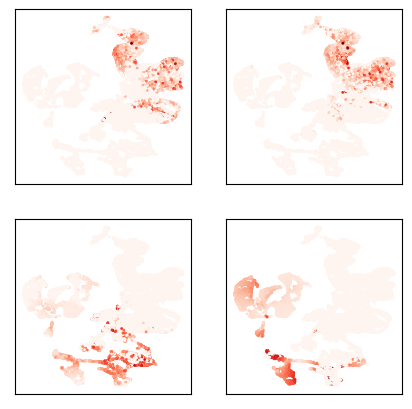

In [195]:
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax = axes.ravel()
embedding = sc_decode.adata.obsm['X_umap']
features_show = []
for i,feature in enumerate(features_show):
    ax[i].scatter(embedding[:,0],embedding[:,1], s=1, c=sc_decode.intens_mtx[feature], cmap='Reds', alpha=1,vmin=0,rasterized=True)
    plt.setp(ax, xticks=[], yticks=[])
plt.savefig('../figures/sc_umap_dist_cor_corp_top.pdf',dpi=300)


In [123]:
regions = []
data = []
mapping = {'corpus collusum':'Corpus','cortex':'Cortex','hippocampal region':'Hip','striatum':'Striatum','thalamus':'Thalamus'}
for key in mapping.keys():
    region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1))))
    region_data = tiss_decode.intens_mtx.iloc[region_idx[region_idx>=0]]
    cos = []
    for value in mapping.values():
        sc_region = sc_decode.intens_mtx.loc[sc_decode.metadata['types']==value]
        #cos.append((cosine_similarity(region_data,sc_region).min()))
        cos.append(np.percentile(cosine_similarity(region_data,sc_region),95).mean())
    data.append(cos)
    regions+=[key]*region_data.shape[0]
# df = pd.DataFrame(np.concatenate(data))
# df['region'] = regions